# Intro

In [1]:
lapply(strsplit('tidyverse lubridate zoo cmdstanr', split = ' ')[[1]],
       require, character.only = TRUE)

theme_set(theme_bw(base_size = 18))
fig = \(height,width) options(repr.plot.height = height, repr.plot.width = width)

cbind.fill = function(a,b) {    
    require(stringi)
    # avoid to shadow on the existing columns
    cols = c(colnames(a), colnames(b))
    id = 'id'
    while(id %in% colnames(a)) id = stri_rand_strings(1,10)
    full_join(
        a %>% mutate(!!id := row_number()),
        b %>% mutate(!!id := row_number()),
        by = id
    ) %>% select(-!!id)
}

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lubridate


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: cmdstanr

This is cmdstanr version 0.4.0

- Online documentation and vignettes at mc-stan.org/cmdstanr

- CmdStan path set to: /opt/conda/bin/cmdstan

- Use set_cmdstan_path() to change the path



[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

# Rt with imported cases

## Build Stan model

Below Stan model based on [Nakajo et al.(2021)](https://doi.org/10.3390/jcm10061256). 

Loading required package: ggpubr

Warning message:
“Removed 13 rows containing missing values (geom_point).”


[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

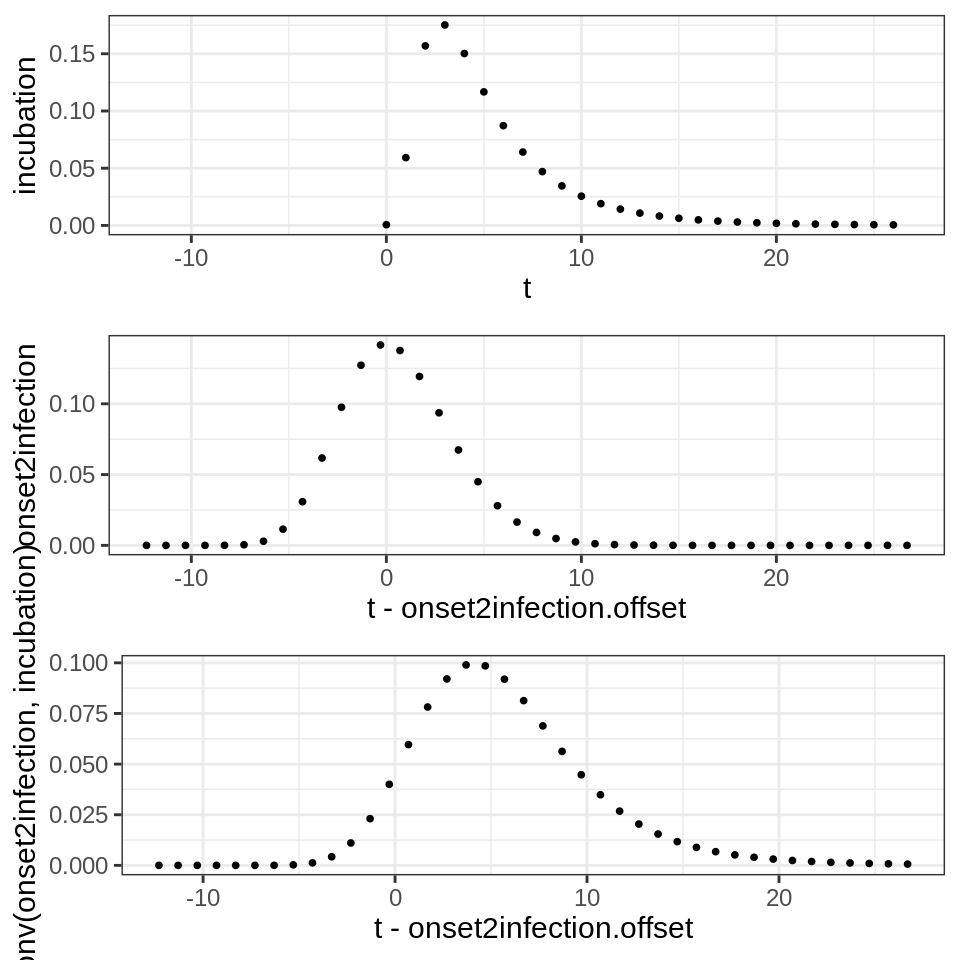

In [2]:
incubation.dist = \(t) plnorm(t, meanlog=1.434065, sdlog=0.6612)

onset2infection.offset = 12.3
onset2infection.dist = \(t) pgamma(t+onset2infection.offset, shape=20.5, rate=1.59)

dist2dens = \(dist) \(t) dist(t+.5) - dist(t-.5)

conv = function(x,k) {
    N = length(x)
    K = length(k)
    rev_k = rev(k)
    y = c()
    for(t in 1:N) y[t] = sum(x[max(1,t-K+1):t] * rev_k[max(1,K-t+1):K])
    y
}

t = seq(0, by = 1, length.out = 40)

incubation = dist2dens(incubation.dist)(t)
onset2infection = dist2dens(onset2infection.dist)(t-onset2infection.offset)

g1 = qplot(t, incubation, xlim = c(min(t), max(t)) - onset2infection.offset)
g2 = qplot(t-onset2infection.offset, onset2infection)
g3 = qplot(t-onset2infection.offset, conv(onset2infection, incubation))

require(ggpubr)
fig(width = 8, height = 8)
ggarrange(g1,g2,g3, ncol=1, align = 'h')
# qplot(t-40+onset2infection.offset, conv(incubation, onset2infection))

lapply(strsplit('readr stringr cmdstanr', split = ' ')[[1]],
       require, character.only = TRUE)

model = cmdstan_model(write_stan_file(str_interp('
functions {
${read_file("../library/conv.stan")}
}

data {
    int N;
    vector<lower=0>[N] domestic;
    vector<lower=0>[N] import;

    int K;
    int D; // offset of onset2infection
    vector<lower=0>[K] onset2infection;
    vector<lower=0>[K] incubation;

    int M; // # of R
    int<lower=1,upper=M> R_index[N];
}

transformed data {
    real EPS = 1e-12;
    real MAX_R = 20;
}

parameters {
    vector<lower=0, upper=MAX_R>[M] R;
        
}

transformed parameters {
    vector[N-D] Rt;
    for(t in 1:(N-D)) Rt[t] = R[R_index[t]];

    vector[N] onset_1st = domestic + import;    
    vector[N-D] infection_2nd = Rt .* conv(onset2infection, onset_1st)[(D+1):N];
    vector[N-D] domestic_2nd = conv(incubation, infection_2nd);
}

model {
    target += gamma_lpdf(domestic_2nd + EPS | domestic[1:(N-D)] + 1, 1);
}
')))

## Load data

In [3]:
domestic_cases = read_csv('../data/newly_confirmed_cases_daily.csv') %>%
    transmute(
        date = ymd(Date),
        n = ALL
    )

Rows: 711 Columns: 49

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Date
dbl (48): ALL, Hokkaido, Aomori, Iwate, Miyagi, Akita, Yamagata, Fukushima, ...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [4]:
system('nkf --in-place -w ../data/quarantine.csv')
quarantine = read_csv('../data/quarantine.csv', col_names = FALSE) %>%
    transmute(
        index = X1,
        port = X3,
        confirmed = ymd(X4),
        arrival = ymd(X5),
        age = X6,
        sex = X7,
        residence = X8,
        departure = X9
    ) %>%
    dplyr::filter(index > 0) %>%
    group_by(index) %>% slice(1) %>% ungroup() # remove duplicates

Rows: 7579 Columns: 16

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (13): X3, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16
dbl   (2): X1, X2
date  (1): X4


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Warning message:
“ 229 failed to parse.”


In [5]:
quarantine_cases = quarantine %>%
    # dplyr::filter(!is.na(arrival)) %>% group_by(date=arrival) %>%
    group_by(date=confirmed) %>%
    count()

cases = full_join(
    domestic_cases %>% rename(domestic = n),
    quarantine_cases %>% rename(import = n),
    by = 'date'
) %>%
    complete(date = full_seq(date, period=1)) %>%
    arrange(date) %>%
    na.trim(sides = 'right', is.na = 'any') %>%
    mutate(across(where(is.numeric), ~ replace_na(., 0)))

## Plot

In [6]:
t = seq(0,by=1,length.out=40)

cases = cases %>%
    # group_by(id = format(date, '%Y%W') %>% { as.numeric(.) %/% 2 }) %>%
    group_by(id = format(date, '%Y%m')) %>%
    # group_by(id = row_number() %/% 14) %>%
    # group_by(id = format(date, '%Y%W')) %>%
    mutate(id = cur_group_id()) %>%
    ungroup()

data = list(
    N = nrow(cases),
    domestic = cases$domestic,
    import = cases$import,
    
    M = max(cases$id),
    R_index = cases$id,
    
    K = length(t),
    D = floor(onset2infection.offset),
    onset2infection = dist2dens(onset2infection.dist)(t-floor(onset2infection.offset)),
    incubation = dist2dens(incubation.dist)(t)    
)

require(rlang)
fit0 = model$variational(refresh = 0, data = ll(import = cases$import * 0, !!!data))
fit1 = model$variational(refresh = 0, data = data)
fit2 = model$variational(refresh = 0, data = ll(import = cases$import * 3, !!!data))
fit3 = model$variational(refresh = 0, data = ll(import = cases$import * 10, !!!data))

Loading required package: rlang


Attaching package: ‘rlang’


The following objects are masked from ‘package:purrr’:

    %@%, as_function, flatten, flatten_chr, flatten_dbl, flatten_int,
    flatten_lgl, flatten_raw, invoke, list_along, modify, prepend,
    splice




Finished in  3.0 seconds.
Finished in  3.0 seconds.
Finished in  3.1 seconds.
Finished in  3.6 seconds.


Loading required package: stringi

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 16 row(s) containing missing values (geom_path).”
Warning message:
“Removed 48 row(s) containing missing values (geom_path).”


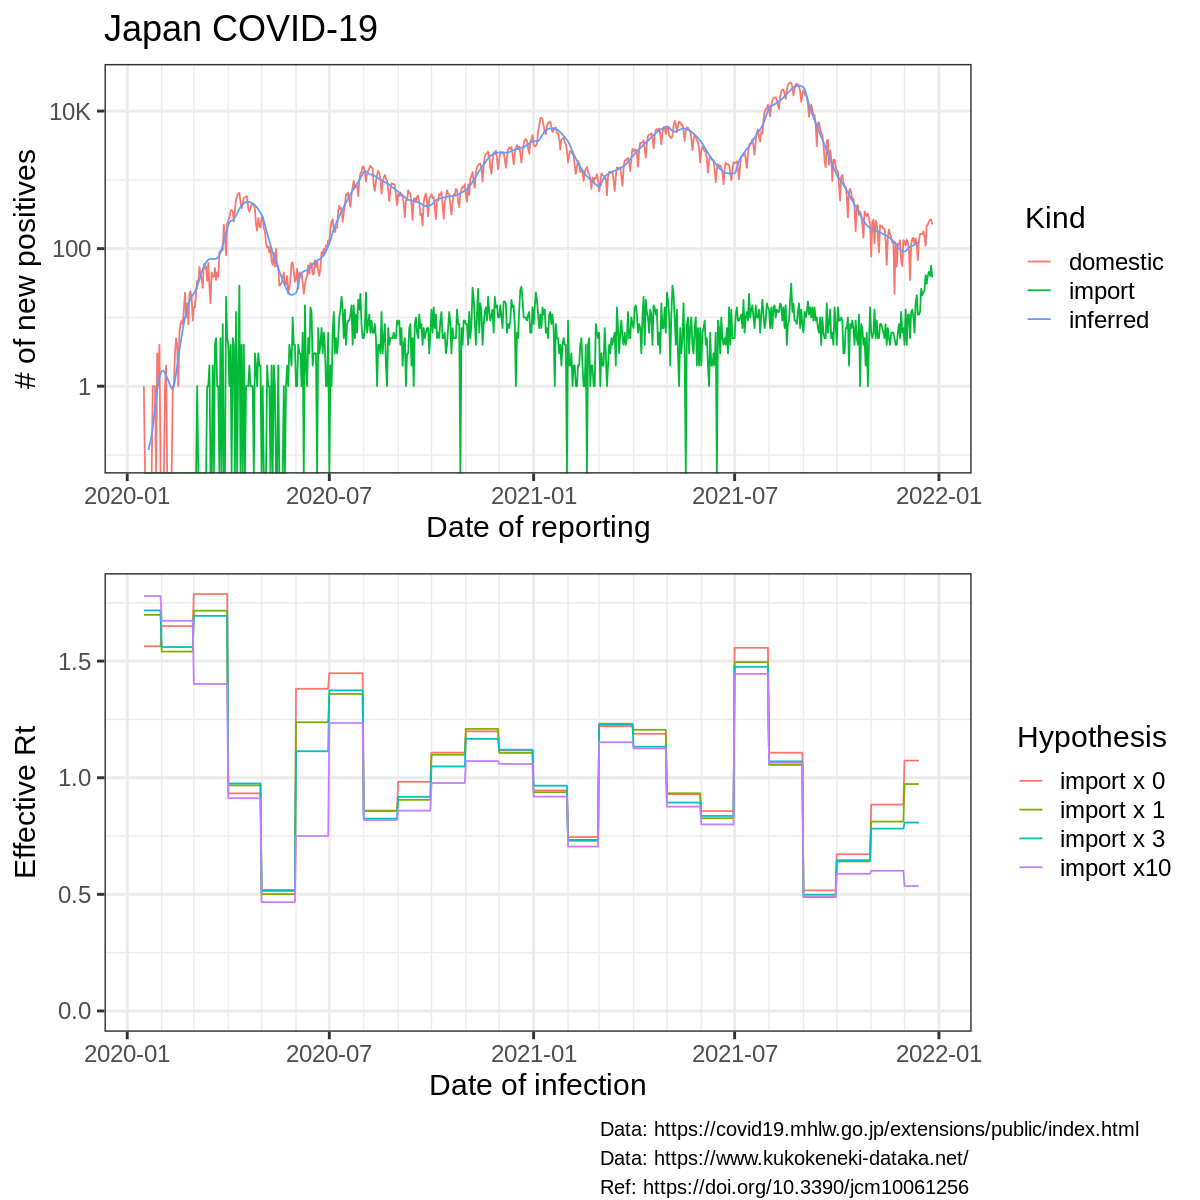

In [7]:
Rt0 = fit0$summary('Rt', 'mean') %>% transmute('import x 0' = mean)
Rt1 = fit1$summary('Rt', 'mean') %>% transmute('import x 1' = mean)
Rt2 = fit2$summary('Rt', 'mean') %>% transmute('import x 3'  = mean)
Rt3 = fit3$summary('Rt', 'mean') %>% transmute('import x10' = mean)

cases %>%
    select(date) %>%
    cbind.fill(Rt0) %>%
    cbind.fill(Rt1) %>%
    cbind.fill(Rt2) %>%
    cbind.fill(Rt3) %>%
    pivot_longer(-date) %>%
ggplot() +
    geom_line(aes(date, value, color=name)) +
    scale_x_date(date_minor_breaks = '1 month') +
    scale_y_continuous(
        # breaks = seq(0,10,by=.2),
        limits = c(0,NA),
    ) -> g1
    # scale_x_date(limits = ymd(c('2021/1/1', NA))) 
    
cases %>%
    arrange(date) %>%
    cbind.fill(fit1$summary('domestic_2nd', 'mean') %>% transmute('inferred' = mean)) %>%
    select(date, domestic, import, inferred) %>%
    pivot_longer(-date) %>%
    group_by(name) %>%
    # arrange(date) %>%
    # mutate(value = rollmean(value, align = 'center', k=14, na.pad = TRUE)) %>%
ggplot() +
    geom_line(aes(date, value, color=name)) +
    scale_x_date(date_minor_breaks = '1 month') +
    scale_y_log10(
        labels = scales::label_number_si(),
        limits = c(0.1, NA)
    ) -> g2
        
fig(10,10)
theme_set(theme_bw(base_size = 18))
ggarrange(
    g2 + 
        labs(
            title = 'Japan COVID-19',
            y = '# of new positives',
            x = 'Date of reporting',
            color = 'Kind'
        ), # + theme(legend.position = 'bottom'),
    g1 + 
        labs(
            y = 'Effective Rt',
            x = 'Date of infection',
            color = 'Hypothesis',
        ), # + theme(legend.position = 'bottom'),
    ncol=1,
    align = 'v'        
) %>%
    annotate_figure(
        bottom = text_grob(just = 'left', label = paste(sep = '\n',
            'Data: https://covid19.mhlw.go.jp/extensions/public/index.html',
            'Data: https://www.kukokeneki-dataka.net/',
            'Ref: https://doi.org/10.3390/jcm10061256'))
    )

# Estimate effectiveness of testing to reduce transmission

## Ct vs. Secondary Attack Cases

In [8]:
# https://www.medrxiv.org/content/10.1101/2021.02.28.21252608v2

CtSAR = read_csv('../data/Ct_SAR.csv')
CtSAR

Rows: 22 Columns: 5

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Ct
dbl (4): primary, contact, secondary, attack rate


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



Ct,primary,contact,secondary,attack rate
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
<18,155,340,72,21
18,205,415,177,43
19,488,1001,357,36
20,998,2141,674,31
21,1710,3668,1149,31
22,2618,5710,1689,30
23,3371,7251,2056,28
24,3918,8511,2216,26
25,4407,9674,2360,24


In [9]:
CtSAR = CtSAR %>%
    slice(-1) %>% # ignore 1st record, it's negligible for latter analysis
    mutate(Ct = as.integer(Ct))

Loading required package: GGally

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



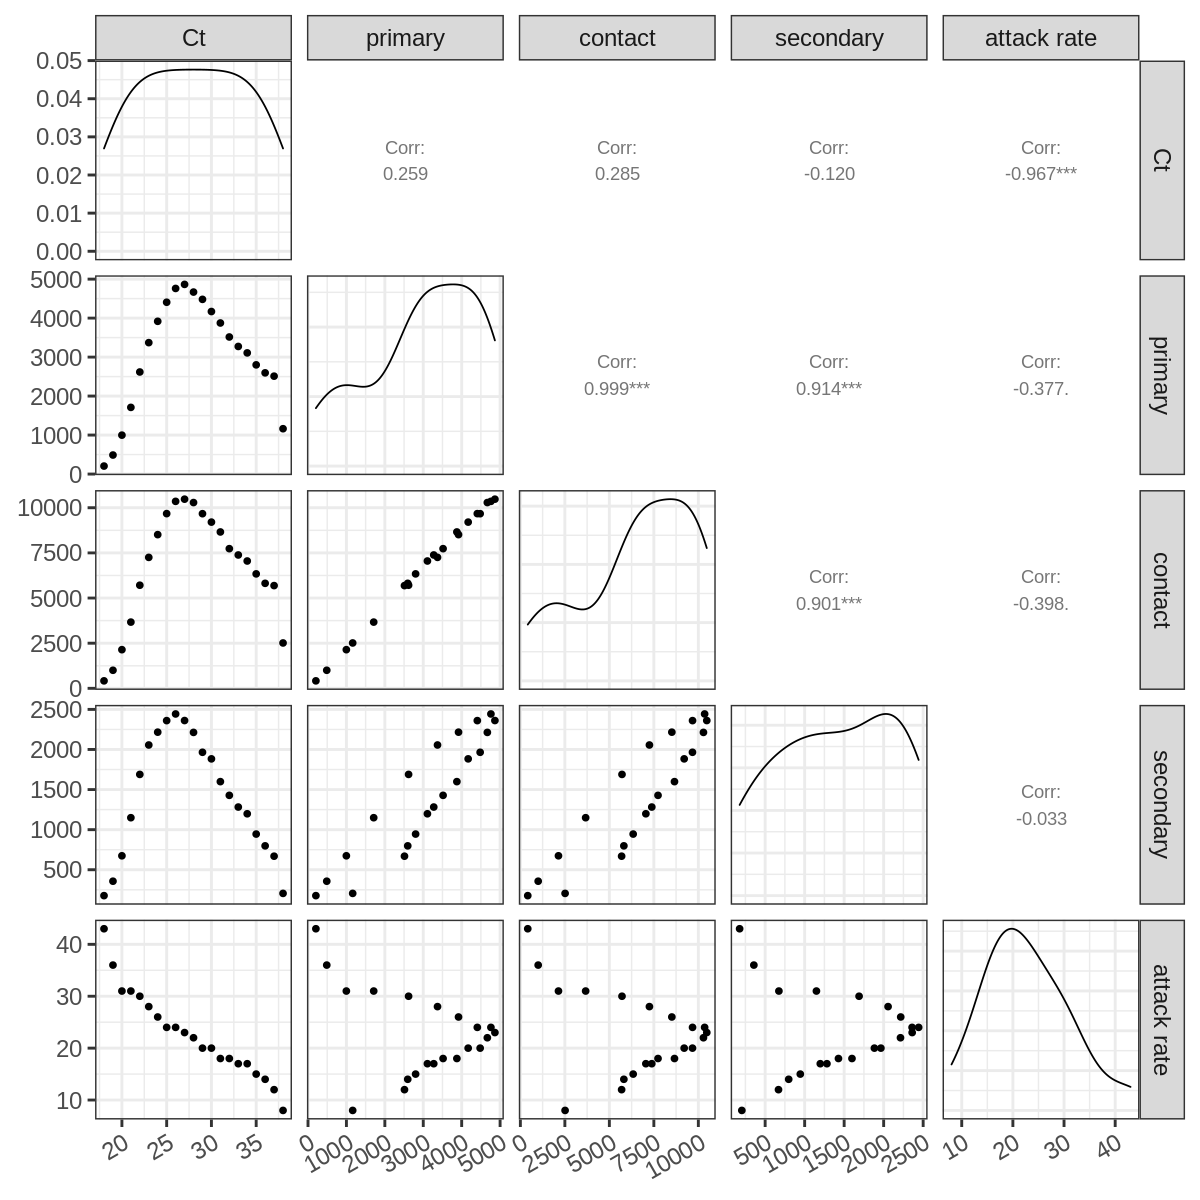

In [10]:
require(GGally)
CtSAR %>%
    mutate(Ct = as.integer(Ct)) %>%
    filter(!is.na(Ct)) %>%
ggpairs() +
    theme(axis.text.x = element_text(angle = 30, hjust = 1))

## Sensitivity of tests

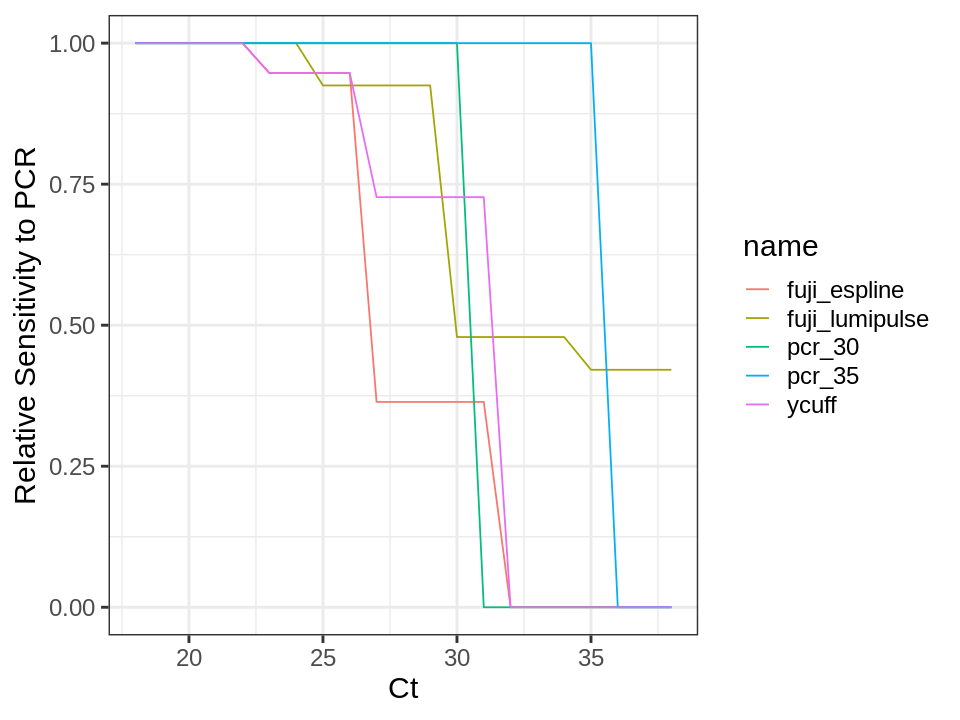

In [11]:
# https://www.medrxiv.org/content/10.1101/2021.01.27.21250659v1
# https://www.medrxiv.org/content/10.1101/2021.01.26.21250533v1

ycuff = \(Ct) case_when(
    Ct < 23 ~ 1.000,
    Ct < 27 ~ 0.947,
    Ct <= 31 ~ 0.727,
    TRUE ~ 0
)

fuji_espline = \(Ct) case_when(
    Ct < 23 ~ 1.000,
    Ct < 27 ~ 0.947,
    Ct <= 31 ~ 0.364,
    TRUE ~ 0.000
)

fuji_lumipulse = \(Ct) case_when(
    Ct < 18 ~ 1.000,
    Ct < 25 ~ 1.000,
    Ct < 30 ~ 0.925,
    Ct < 35 ~ 0.479,
    Ct <= 40 ~ 0.421,
    TRUE ~ 0.000
)

pcr = \(Ct, cutoff)  case_when(
    Ct <= cutoff ~ 1.000,
    TRUE ~ 0.000
)

CtSAR %>%
    transmute(
        Ct,
        ycuff = ycuff(Ct),
        fuji_espline = fuji_espline(Ct),
        fuji_lumipulse = fuji_lumipulse(Ct),
        pcr_30 = pcr(Ct, 30),
        pcr_35 = pcr(Ct, 35),
    ) %>%
    pivot_longer(-Ct) %>%
ggplot() +
    geom_line(aes(Ct, value, color=name)) +
    labs(y = 'Relative Sensitivity to PCR') -> g

fig(6,8)
g

## Relative proportion of secondary cases

Effective reproduction number $R_t$ is equal to the number of secondary cases per primary case. So effectiveness of test-and-isolate can be estimated by using a distribution of secondary cases in real-world population that reflect actual transmission dynamics. After test-and-isolate with test sensitivity $p(\theta)$ and PCR cycle threshold(Ct) $\theta$, relative reproduction number $R^\prime_t/R_t$ is proportional to relative proportion of secondary cases:
$$\frac{R^\prime_t}{R_t} = \frac{\int (1-p(\theta)) j(\theta) d\theta}{\int j(\theta) d\theta}$$
where $j(\theta)$ is a number of secondary cases with Ct $\theta$.

In [12]:
test.spec = data.frame()
test.spec.add = \(name, rp, cutoff) {
    test.spec <<- rbind(test.spec, list(
        name=name, relative_proportion=rp, cutoff_at_same_proportion=cutoff
    ))
}

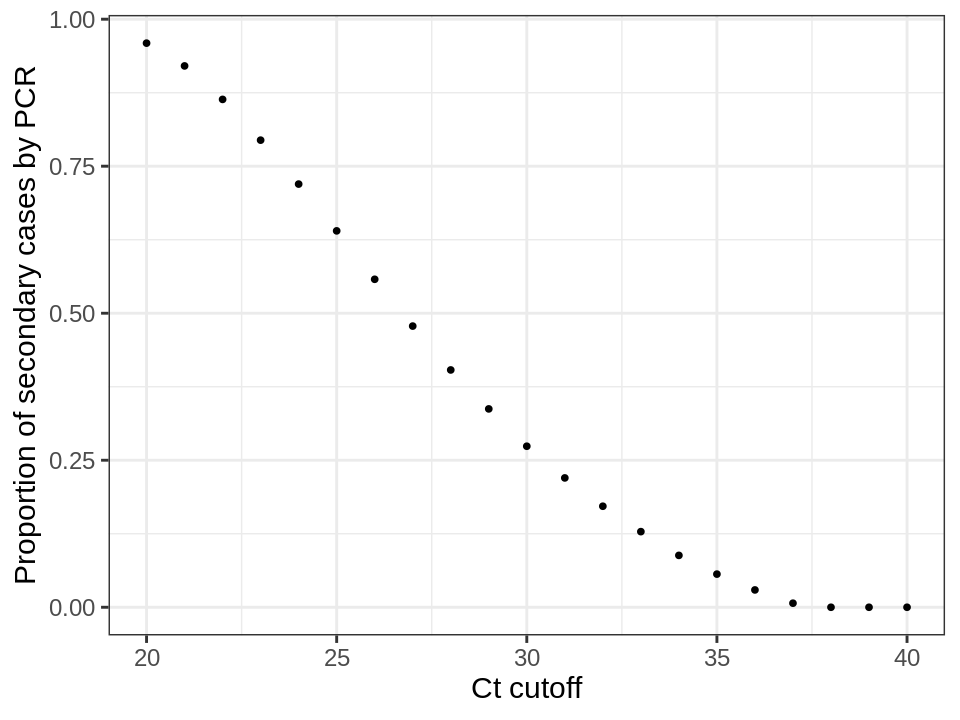

In [13]:
# PCR with cutoff
cutoff = seq(20, 40)
pcr_rp = \(cutoff) with(CtSAR, sum(secondary * (1-pcr(Ct, cutoff))) / sum(secondary))

test.spec.add('PCR <35', pcr_rp(35), 35)

qplot(cutoff, Vectorize(pcr_rp)(cutoff)) +
    labs(x = 'Ct cutoff', y = 'Proportion of secondary cases by PCR')

In [14]:
rp2cutoff = approxfun(Vectorize(pcr_rp)(cutoff), cutoff)
rp2cutoff(.5)
# rp2(0) has multiple values as above, so warning.

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] 26.72533

In [15]:
# https://www.medrxiv.org/content/10.1101/2021.01.27.21250659v1
# ycu-ff
ycuff_rp = with(CtSAR, sum(secondary * (1-ycuff(Ct))) / sum(secondary))
test.spec.add('YCU-FF', ycuff_rp, rp2cutoff(ycuff_rp))

# Fuji Espline
fuji_espline_rp = with(CtSAR, sum(secondary * (1-fuji_espline(Ct))) / sum(secondary))
test.spec.add('Fuji Espline', fuji_espline_rp, rp2cutoff(fuji_espline_rp))

# https://www.medrxiv.org/content/10.1101/2021.01.26.21250533v1
# Fuji Lumipulse
fuji_lumipulse_rp = with(CtSAR, sum(secondary * (1-fuji_lumipulse(Ct))) / sum(secondary))
test.spec.add('Fuji Lumipulse', fuji_lumipulse_rp, rp2cutoff(fuji_lumipulse_rp))

test.spec %>% mutate(across(where(is.numeric), ~ signif(.,digits = 3)))

name,relative_proportion,cutoff_at_same_proportion
<chr>,<dbl>,<dbl>
PCR <35,0.0564,35.0
YCU-FF,0.3280,29.1
Fuji Espline,0.4510,27.4
Fuji Lumipulse,0.2100,31.2


https://www.covid19-jma-medical-expert-meeting.jp/topic/6489
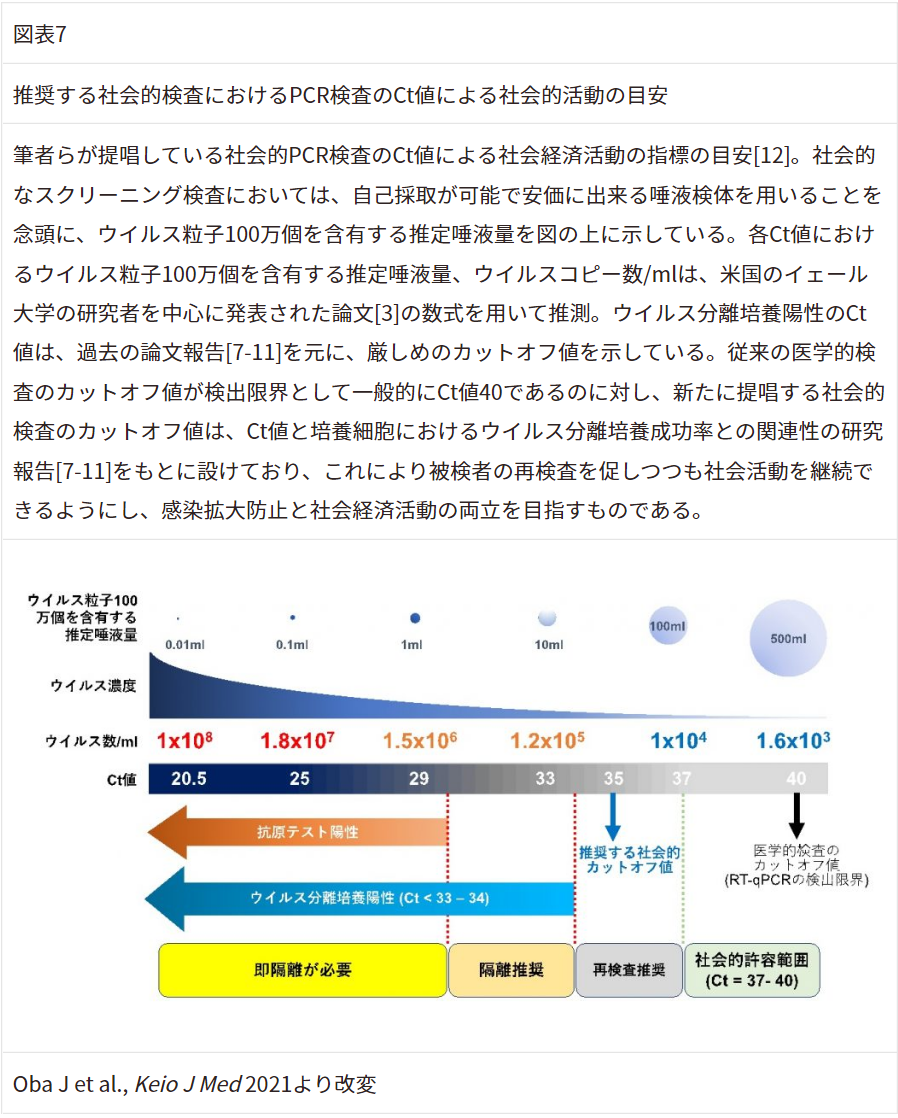